In [1]:
import os, sys
import numpy as np
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne
import random

In [2]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
data_path = "../MRNet/MRNet-v1.0/train/axial"
filelist = os.listdir(data_path)
filelist.remove('.DS_Store')

In [4]:
# Check the largest volume
# max_slice = 0
# for file in filelist:
#     img = np.load(os.path.join(data_path, file))
#     if img.shape[0] > max_slice:
#         max_slice = img.shape[0]
# print(max_slice)

In [5]:
max_slice = 64
slice_x = 256
slice_y = 256

In [6]:
def vxm_data_generator(filelist, batch_size=32):
    """
    Generator that yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """
    fixed_img_paths = random.choices(filelist, k=batch_size)
    moving_img_paths = random.choices(filelist, k=batch_size)

    fixed_img_list = []
    for fixed_img_path in fixed_img_paths:
        fixed_img = np.load(os.path.join(data_path, fixed_img_path))
        num_slice_to_pad = max_slice - fixed_img.shape[0]
        fixed_img = np.pad(fixed_img, ((0, num_slice_to_pad), (0, 0), (0, 0)), 'constant')
        fixed_img_list.append(fixed_img)
    
    moving_img_list = []
    for moving_img_path in moving_img_paths:
        moving_img = np.load(os.path.join(data_path, moving_img_path))
        num_slice_to_pad = max_slice - moving_img.shape[0]
        moving_img = np.pad(moving_img, ((0, num_slice_to_pad), (0, 0), (0, 0)), 'constant')
        moving_img_list.append(moving_img)

    fixed_images = np.array(fixed_img_list) / 255.0
    fixed_images = np.expand_dims(fixed_images, -1)
    moving_images = np.array(moving_img_list) / 255.0
    moving_images = np.expand_dims(moving_images, -1)

    vol_shape = (max_slice, slice_x, slice_y)
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
    
        yield (inputs, outputs)

In [7]:
train_generator = vxm_data_generator(filelist, 1)
in_sample, out_sample = next(train_generator)

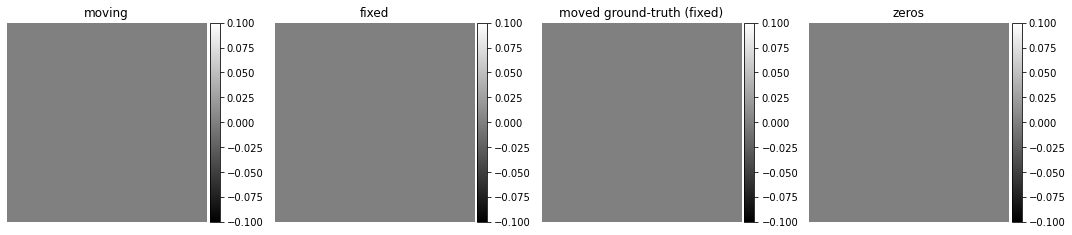

(<Figure size 1080x270 with 8 Axes>,
 array([<AxesSubplot:title={'center':'moving'}>,
        <AxesSubplot:title={'center':'fixed'}>,
        <AxesSubplot:title={'center':'moved ground-truth (fixed)'}>,
        <AxesSubplot:title={'center':'zeros'}>], dtype=object))

In [8]:
# visualize
images = [img[0, 32, :, :, 0] for img in in_sample + out_sample] 
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True)

In [9]:
# configure unet features 
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]

vol_shape = (max_slice, slice_x, slice_y)
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)

Instructions for updating:
Use fn_output_signature instead


In [10]:
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

In [11]:
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

In [12]:
checkpoint_path = "../model_cp/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
print(checkpoint_dir)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True)

../model_cp


In [ ]:
nb_epochs = 10
steps_per_epoch = 100
hist = vxm_model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2)

Epoch 1/10


C:\Users\Yixing\AppData\Local\Temp/ipykernel_6432/3659163062.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = vxm_model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2)
